# NVIDIA Stock Price Prediction using LSTM

This notebook demonstrates how to use LSTM (Long Short-Term Memory) networks to predict NVIDIA stock prices using PyTorch.

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

## Load and Prepare Data

In [2]:
# Load the data
df = pd.read_csv('NVDA.csv')  # Adjust filename as needed
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Add technical indicators
def add_technical_indicators(df):
    # Rolling mean
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # Rolling standard deviation
    df['STD_20'] = df['Close'].rolling(window=20).std()
    
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    
    return df.fillna(method='bfill')

# Apply technical indicators
df = add_technical_indicators(df)

C:\Users\EverGarden13\AppData\Local\Temp\ipykernel_27232\3294765627.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method='bfill')


In [3]:
class StockDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.sequence_length = sequence_length
        
        # Select features for training
        self.features = ['Close', 'Open', 'High', 'Low', 'Volume',
                       'SMA_20', 'SMA_50', 'STD_20', 'RSI', 'MACD']
        
        # Scale all features
        self.scaler = MinMaxScaler()
        self.scaled_data = self.scaler.fit_transform(data[self.features])
        
        # Create sequences
        X, y = [], []
        for i in range(len(self.scaled_data) - sequence_length):
            X.append(self.scaled_data[i:(i + sequence_length)])
            y.append(self.scaled_data[i + sequence_length, 0])  # 0 index is Close price
            
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def inverse_transform_close(self, data):
        # Create a dummy array with zeros for other features
        dummy = np.zeros((len(data), len(self.features)))
        dummy[:, 0] = data  # Put the close price in first column
        # Inverse transform and return only the Close price column
        return self.scaler.inverse_transform(dummy)[:, 0]

## Define LSTM Model

In [4]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        
        # Attention layer
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        out = self.fc(context_vector)
        return out

## Train the Model

In [5]:
def train_model(model, train_loader, val_loader, epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch.unsqueeze(1)).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

In [6]:
# Model parameters
input_size = 10
hidden_size = 128
num_layers = 2
sequence_length = 30
batch_size = 32

# Create datasets
dataset = StockDataset(df, sequence_length)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model
model = AttentionLSTM(input_size, hidden_size, num_layers)

# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader)

C:\Users\EverGarden13\AppData\Local\Temp\ipykernel_27232\934316258.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  self.X = torch.FloatTensor(X)


Epoch [10/100], Train Loss: 0.0006, Val Loss: 0.0004
Epoch [20/100], Train Loss: 0.0005, Val Loss: 0.0002
Epoch [30/100], Train Loss: 0.0005, Val Loss: 0.0001
Epoch [40/100], Train Loss: 0.0004, Val Loss: 0.0001
Epoch [50/100], Train Loss: 0.0004, Val Loss: 0.0001
Epoch [60/100], Train Loss: 0.0004, Val Loss: 0.0001
Epoch [70/100], Train Loss: 0.0004, Val Loss: 0.0001
Early stopping at epoch 71


## Evaluate Model Performance

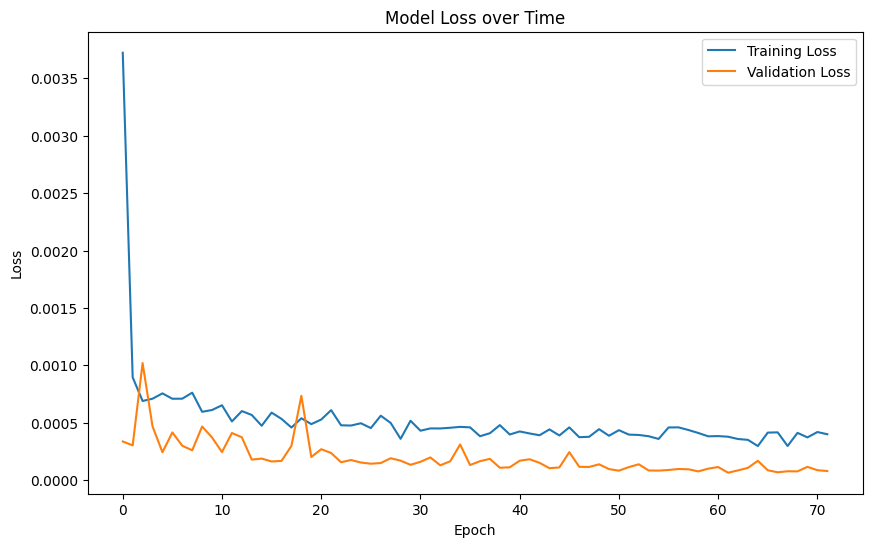

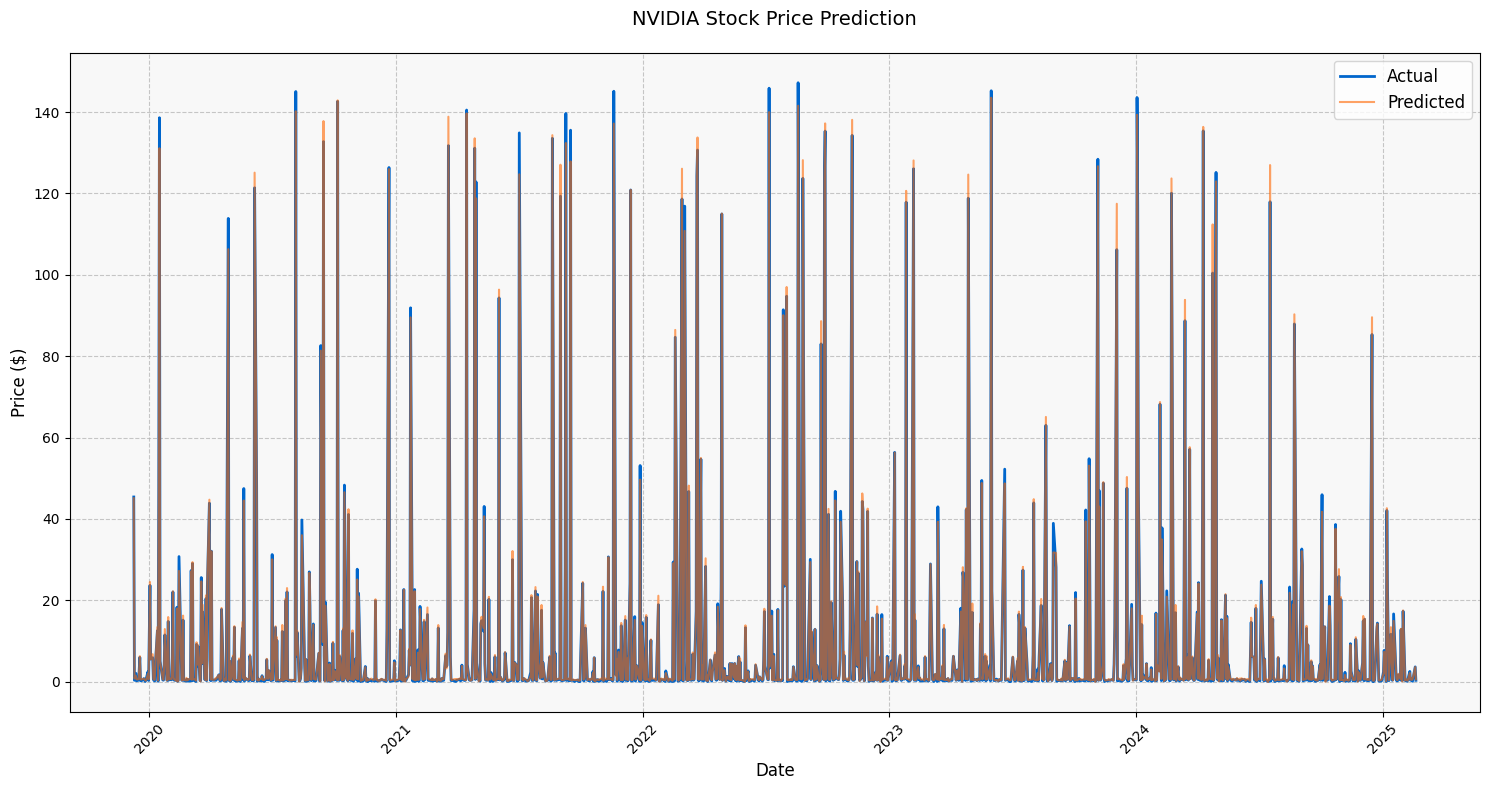

In [7]:
# Plot training results
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/LSTM/training_loss.png')
plt.show()

# Load best model for predictions
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Make predictions
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch)
        predictions.extend(y_pred.numpy().flatten())
        actuals.extend(y_batch.numpy().flatten())

# Convert predictions and actuals back to original scale
predictions = dataset.inverse_transform_close(np.array(predictions))
actuals = dataset.inverse_transform_close(np.array(actuals))

# Plot predictions vs actual
plt.figure(figsize=(15, 8))  # Increased figure size

# Plot with improved styling
plt.plot(df.index[-len(predictions):], actuals, 
         label='Actual', 
         linewidth=2, 
         color='#0066cc')  # Solid blue line for actual values

plt.plot(df.index[-len(predictions):], predictions, 
         label='Predicted', 
         linewidth=1.5, 
         color='#ff6600',  # Orange color for predictions
         alpha=0.6)        # Slight transparency for predicted values

# Enhance the plot appearance
plt.title('NVIDIA Stock Price Prediction', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=12)

# Improve grid and background
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f8f8f8')  # Light gray background

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.savefig('plots/LSTM/stock_predictions.png')
# Show the plot
plt.show()

In [8]:
# Model Evaluation Metrics
model.eval()
with torch.no_grad():
    # Get predictions for training data
    train_predictions = []
    train_actuals = []
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        train_predictions.extend(y_pred.numpy().flatten())
        train_actuals.extend(y_batch.numpy().flatten())
    
    # Get predictions for validation data
    val_predictions = []
    val_actuals = []
    for X_batch, y_batch in val_loader:
        y_pred = model(X_batch)
        val_predictions.extend(y_pred.numpy().flatten())
        val_actuals.extend(y_batch.numpy().flatten())

# Convert to numpy arrays and inverse transform
train_predictions = dataset.inverse_transform_close(np.array(train_predictions))
train_actuals = dataset.inverse_transform_close(np.array(train_actuals))
val_predictions = dataset.inverse_transform_close(np.array(val_predictions))
val_actuals = dataset.inverse_transform_close(np.array(val_actuals))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(train_actuals, train_predictions))
val_rmse = np.sqrt(mean_squared_error(val_actuals, val_predictions))

# Calculate R2 Score
train_r2 = r2_score(train_actuals, train_predictions)
val_r2 = r2_score(val_actuals, val_predictions)

# Calculate accuracy (percentage of predictions within 5% of actual values)
def calculate_accuracy(y_true, y_pred, threshold=0.05):
    within_threshold = np.abs(y_true - y_pred) <= (threshold * np.abs(y_true))
    return np.mean(within_threshold) * 100

train_accuracy = calculate_accuracy(train_actuals, train_predictions)
val_accuracy = calculate_accuracy(val_actuals, val_predictions)

# Print all metrics
print("Training Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"R2 Score: {train_r2:.4f}")
print(f"Accuracy (within 5%): {train_accuracy:.2f}%")
print("\nValidation Metrics:")
print(f"RMSE: {val_rmse:.4f}")
print(f"R2 Score: {val_r2:.4f}")
print(f"Accuracy (within 5%): {val_accuracy:.2f}%")

Training Metrics:
RMSE: 1.0965
R2 Score: 0.9979
Accuracy (within 5%): 23.16%

Validation Metrics:
RMSE: 1.2018
R2 Score: 0.9977
Accuracy (within 5%): 22.59%
